# <center>Sentiment Analysis | Company Reviews</center>

<center>
    <figure>
        <img src="https://www.surveysensum.com/wp-content/uploads/2020/02/SENTIMENT-09-1.png" alt ="Sentiment Analysis" style='width:80%;'>
        <figcaption>
            Source: <a href="https://www.surveysensum.com/customer-experience/sentiment-analysis/">[surveysensum.com | Sentiment Analysis: A Thorough Guide For The Data Geek]</a>
        </figcaption>
    </figure>
</center>

### 🎯 Objective

The objective for this notebook is to build a baseline model which is capable of predicting the sentiment of company reviews left by customers for the [Sentiment Analysis - Company Reviews Competition](https://www.kaggle.com/competitions/sentiment-analysis-company-reviews/overview).

### 🤔 So what exactly is Sentiment Analysis?

**According to [ChatGPT](https://openai.com/blog/chatgpt/):**

> Sentiment analysis, also known as opinion mining, is the process of analyzing and identifying the sentiment, attitude, or emotion expressed in a piece of text, such as a review or a social media post.
>
> It is commonly used in various industries, such as marketing, customer service, and politics, to understand people's opinions, preferences, and behavior. Sentiment analysis uses natural language processing (NLP) techniques and algorithms to analyze and classify text into different categories, such as positive, negative, or neutral.The process involves pre-processing the text, such as tokenization and stemming, to convert it into a format that can be analyzed by the algorithms.
>
>Sentiment analysis models can be trained on a dataset of labeled data, which contains examples of text with their corresponding sentiment labels. Alternatively, models can be trained using unsupervised learning techniques, which use clustering and other methods to classify the text without labeled data.
>
>Sentiment analysis can be performed on various types of text, such as social media posts, product reviews, news articles, and customer feedback. Overall, sentiment analysis is a useful tool for understanding people's opinions and attitudes, and can help businesses make data-driven decisions based on customer feedback.

**For more information on Sentiment Analysis, see the following links:**
> - [MonkeyLearn | Sentiment Analysis: A Definitive Guide](https://monkeylearn.com/sentiment-analysis/)
> - [Thematic | Sentiment Analysis: Comprehensive Beginners Guide](https://getthematic.com/sentiment-analysis/)

### 📁 Dataset
The dataset for this competition (both train and test) consists of 100,000 reviews collected from Trustpilot and spans over 40 different companies.

> Find this competitions dataset here: [Sentiment Analysis - Company Reviews Dataset](https://www.kaggle.com/competitions/sentiment-analysis-company-reviews/data)

<br>
<hr>

## Table of contents

- [1 | Dataset Exploration](#1)
   > - [Load CSV Files](#1.1)
   > - [View Random Selected Samples](#1.2)
   > - [View Train Rating Distribution](#1.3)
   > - [Inspect Review Lengths & Tokens](#1.4)
   > - [View Review Lengths & Review Token Count Histograms](#1.5)
  
- [2 | Data Preprocessing](#2)
   > - [Label Encode Ratings](#2.1)
   > - [Create Train/Validation Split](#2.2)
   > - [View New Train & Validation Labels Distribution](#2.3)
   
- [3 | Build Input Data Pipeline with tf.data API](#3)
   > - [Define Text Preprocessor](#3.1)
   > - [Generate Input Data Pipelines](#3.2)
   
- [4 | Baseline Model: Universal Sentence Encoder Model](#4)
   > - [TensorFlow Hub](#tfhub)
   > - [Get Universal Sentence Encoder](#4.1)
   > - [Build Model](#4.2)

- [5 | Train Baseline Model](#5)
   > - [Define Callbacks and Metrics for Model Training](#5.1)
   > - [Compile & Train Model](#5.2)
   
- [6 | Model Performance Evaluation](#6)
   > - [View Model Histories](#6.1)
   > - [Plot Confusion Matrix](#6.2)
   > - [Generate Classification Reports](#6.3)
   > - [Record Classification Metrics](#6.4)
   
- [7 | Generate Submission](#7)
   > - [Preprocess Test Reviews](#7.1)
   > - [Generate Test Predictions](#7.2)
   > - [Generate Submission.csv](#7.3)
   
- [Conclusion](#conclusion)

<br>
<hr>

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_absolute_error
from scikitplot.metrics import plot_roc

In [2]:
class CFG:
    SEED = 768
    BATCH_SIZE = 32
    EPOCHS = 10

<a id='1'></a>
# 1 | Dataset Exploration        

In [3]:
# Define paths
DATASET_PATH = "/kaggle/input/sentiment-analysis-company-reviews/"
TRAIN_CSV = '/kaggle/input/sentiment-analysis-company-reviews/train.csv'
TEST_CSV = '/kaggle/input/sentiment-analysis-company-reviews/test.csv'
SAMPLE_SUB_CSV = '/kaggle/input/sentiment-analysis-company-reviews/sample_submission.csv'

### Load CSV Files

In [4]:
# Load the csv files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
submission_df = pd.read_csv(SAMPLE_SUB_CSV) 

In [5]:
# Generate summary of the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [6]:
# View first 5 training samples
train_df.head(5)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


<a id='1.2'></a>
### View Random Selected Samples

In [7]:
def view_samples(df, count=5):
    idx = random.sample(train_df.index.to_list(), count)
    print('=========================================\n')
    for _ in idx:
        print(f'id:\t{df.Id[_]}\n')
        print(f'Review:\n{df.Review[_]}\n')
        print(f'Rating:\n{df.Rating[_]}')
        print('=========================================\n')

In [8]:
# View 5 randomly selected samples
view_samples(train_df, count=5)


id:	13813

Review:
I HAD THE GREATEST EXPERIENCE WITH CeX!!!!!!
The product came in perfect condition and it was a class b!!!! the price was great and i would buy again anytime!!!!!!!!!!

Rating:
5

id:	15085

Review:
Honest review . Awesome app! Made my social go up .

Rating:
5

id:	26141

Review:
Rubbish company..just big name...customer service persons are playing a game like passing phone to each other and put me on hold for 2 hours..I am not hear to play a game ...I am not suggesting not to go with bt... rubbish...rubbish

Rating:
1

id:	47628

Review:
I sold my phone for a price much lower than advertised. When I was in the shop, the price seemed to be a bit low but I was busy and then forgot about it. Until a few days later I saw the original price but by then I got horribly sick. Still sick but eventually went back to the shop. Not their problem, head office apparently.

Update: I have filled out the web form and await your response.

Rating:
2

id:	25861

Review:
12 years of

<a id='1.3'></a>
### View Train Rating Distribution

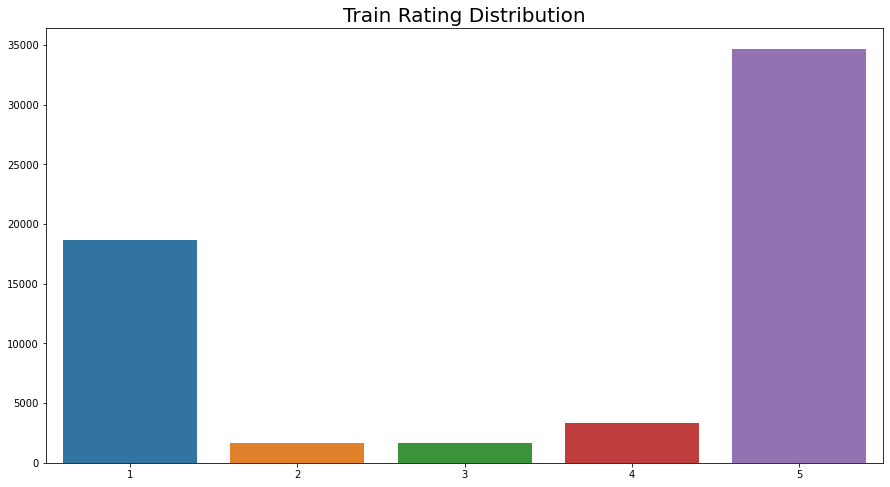

In [9]:
# View Train Rating Distribution
plt.figure(figsize=(15, 8))
plt.title('Train Rating Distribution', fontsize=20)

train_distribution = train_df['Rating'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values);

<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    We observe that <b>the dataset is severly imbalanced</b> with review with ratings of 1 and 5 make up the majority of the dataset's reviews. Techniques such as undersampling, oversampling or weighted training should be considered. However, this notebook will only focus on the baseline model and will not cover the implementation of these techniques. It should be noted that this behavior in the data is most likely representative of customer behavior (customers would rather give a rating of 1 or 5 and ratings in between siginify mixed opinions). 
</div>

<a id='1.4'></a>
### Inspect Review Lengths & Tokens

In [10]:
# Get the lengths of each review
train_df['review_length'] = [len(_) for _ in train_df.Review]

# Get the number of tokens per review 
train_df['token_count'] = [len(_.split()) for _ in train_df.Review]

In [11]:
# View first 5 samples 
train_df.head(5)

,Id,Review,Rating,review_length,token_count
0,0,Very good value and a great tv very happy and ...,5,89,18
1,1,After 6 month still can't access my account,3,43,8
2,2,I couldn't make an official review on a produc...,1,496,92
3,3,"Fantastic! Extremely easy to use website, fant...",5,197,32
4,4,So far annoyed as hell with this bt monthly pa...,1,222,49


In [12]:
# Inspect Review Length Stats
print('Review Length Description')
print('==================================')
print(train_df['review_length'].describe())
print('==================================')

Review Length Description
count    60000.000000
mean       309.070083
std        423.772492
min         31.000000
25%         82.000000
50%        164.000000
75%        358.000000
max       7794.000000
Name: review_length, dtype: float64


In [13]:
# Inspect Token Count Stats
print('Token Count Description')
print('==================================')
print(train_df['token_count'].describe())
print('==================================')

Token Count Description
count    60000.00000
mean        56.56325
std         79.35289
min          1.00000
25%         14.00000
50%         29.00000
75%         66.00000
max       1439.00000
Name: token_count, dtype: float64


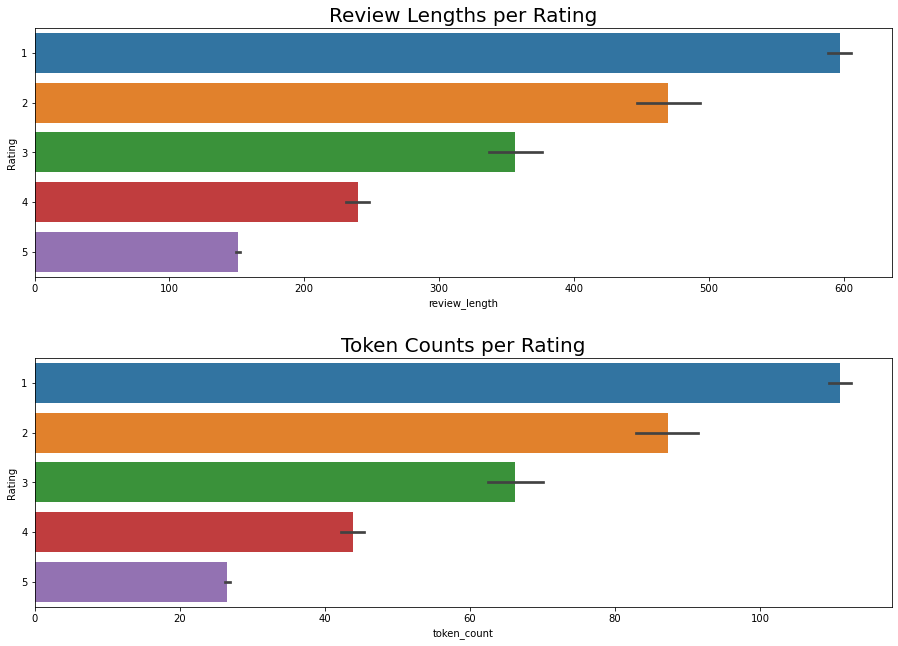

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.barplot(data=train_df, x='review_length', y='Rating',
            orient="h",
            ax=ax1)

# Plot Range of Token Counts per Rating
ax2.set_title('Token Counts per Rating', fontsize=20)
sns.barplot(data=train_df, x='token_count', y='Rating',
            orient="h",
            ax=ax2);

<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    We observe that the length of the reviews increase the more unsatisfied the customers are with the companies. The same observation can be made for the number of tokens per review. The reason for this may be that customers tend to explain or describe their opinions/experiences in great detail the more unsatisfied they are with the companies. This reason may also explain why reviews with higher ratings are generally shorter with less tokens present as this signifies satification amongst customers.
</div>

<a id='1.5'></a>
### View Review Lengths & Review Token Count Histograms

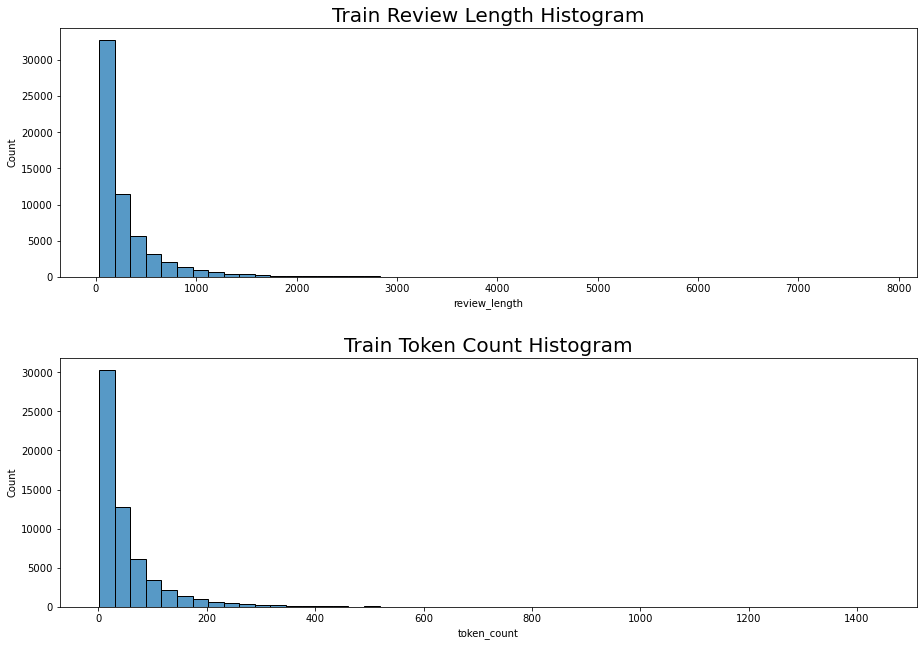

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Generate Train Rating Histogram
ax1.set_title('Train Review Length Histogram', fontsize=20)
sns.histplot(data=train_df, x='review_length', bins=50,
            ax=ax1)

# Generate Train Token Count Histogram
ax2.set_title('Train Token Count Histogram', fontsize=20)
sns.histplot(data=train_df, x='token_count', bins=50,
            ax=ax2);

<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    We observe that the majority of review lengths are under a length of ~1000. We also observe that the review token counts are generally under ~300 tokens. These factors should be considered when selecting the number of tokens to be used in a model. Selecting the number of tokens to be used in model via percentiles may prove to be helpful. However, this will not be covered in this notebook.
</div>

<a id='2'></a>
# 2 | Data Preprocessing

<a id='2.1'></a>
### Label Encode Ratings

We need to label encode the ratings since all ratings fall in the range between 1 and 5 inclusively. To achieve this we simply shift the ratings by subtracting 1 from each rating (e.g. 5 -> 4). We do this in order to simplify the one-hot encoding process at a later stage.

In [16]:
# Label encode ratings
train_df["rating_encoded"] = train_df['Rating'] - 1

<a id='2.2'></a>
### Create Train/Validation Split

In [17]:
# Get indices for train and validation splits
train_idx, val_idx, _, _ = train_test_split(
    train_df.index, train_df.Rating, 
    test_size=0.2, stratify=train_df.Rating,
    random_state=CFG.SEED
)

In [18]:
# Get new training and validation data
train_new_df = train_df.iloc[train_idx].reset_index(drop=True)
val_df = train_df.iloc[val_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((48000, 6), (12000, 6))

In [19]:
# View new train dataframe
train_new_df

,Id,Review,Rating,review_length,token_count,rating_encoded
0,7372,Straight forward purchase from trusted supplie...,5,80,12,4
1,36260,Website is super smooth and easy to navigate w...,5,118,21,4
2,33497,"Apparently it was posted twice, maybe it will ...",1,150,26,0
3,36775,Order received the day after order. Memory upg...,5,94,15,4
4,49630,"Its great, in a contract with them for 30GB fo...",5,162,27,4
...,...,...,...,...,...,...
47995,40748,I have made 2 purchases with PCSPECIALIST in t...,5,91,17,4
47996,33270,Matress is amazing- thank you\nYet again deliv...,2,402,78,1
47997,16802,Gtech have a great product I always buy from t...,5,134,25,4
47998,37531,"Quick delivery, competitive price",5,33,4,4


<a id='2.3'></a>
### View Train & Validation Rating Distributions

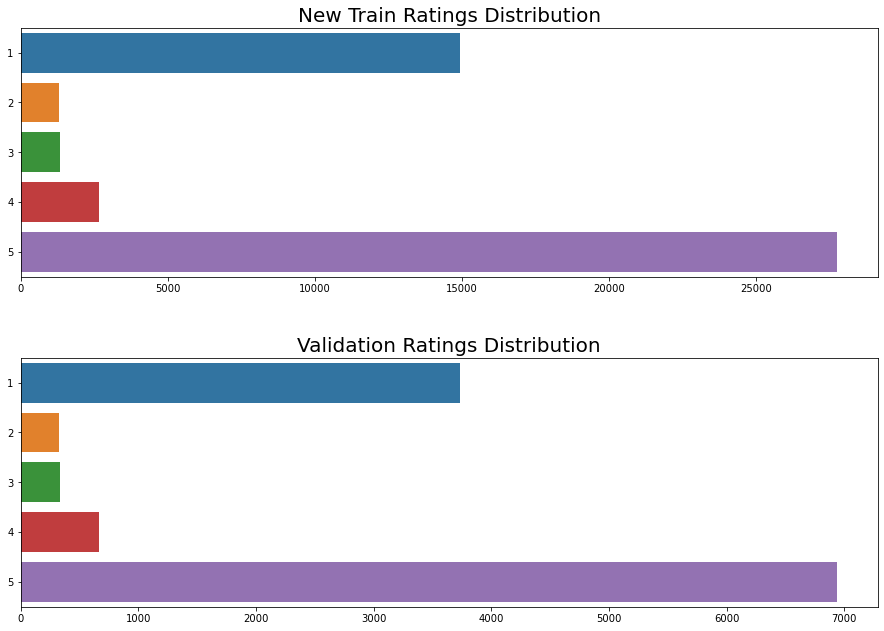

In [20]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Ratings Distribution
ax1.set_title('New Train Ratings Distribution', fontsize=20)
train_new_distribution = train_new_df['Rating'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Ratings Distribution
ax2.set_title('Validation Ratings Distribution', fontsize=20)
val_distribution = val_df['Rating'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

<a id='3'></a>
# 3 | Build Input Data Pipeline with tf.data API

In this notebook we'll use the tf.data API to build input data pipelines for training a model and conducting model inference. In order to achieve this, we'll preprocess the reviews by removing any artifacts in the texts such as emojis, non-ascii characters and replacing numbers with another character. The preprocessed texts will be used to construct the pipelines along with the one-hot encoded ratings.

<center>
    <figure>
        <img src="https://i.postimg.cc/GpPNLLNH/1-3-Zi3-VUAYh5w78-KGLo-O37g.webp" alt ="UCF101" style='width: 800px;'>
        <figcaption>
            Source: <a href="https://towardsdatascience.com/how-to-reduce-training-time-for-a-deep-learning-model-using-tf-data-43e1989d2961">[Medium | How to Reduce Training Time for a Deep Learning Model using tf.data]</a>
        </figcaption>
    </figure>
</center>

<br>

**For more information on the tf.data API and loading data from generator, follow these links:** 
> - [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
> - [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)
> - [Using generators with tf.data API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator)

<a id='3.1'></a>
### Define Text Preprocessor

In [21]:
def text_preprocessor(text):
    
    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # -----------------------------------------------------
    non_ascii_pattern = re.compile(r"[^\x00-\x7F]+", flags=re.UNICODE)
    digit_pattern = re.compile('[0-9]', flags=re.UNICODE)
    
    # Remove emojis
    preprocessed_text = emoji_pattern.sub(r'', text)
    # Remoce non-ascii characters
    preprocessed_text = non_ascii_pattern.sub(r'', preprocessed_text)
    # Replace numbers with '@' sign
    preprocessed_text = digit_pattern.sub(r'#', preprocessed_text)
    
    return preprocessed_text

<a id='3.2'></a>
### Generate Input Data Pipelines

In [22]:
def encode_labels(labels, label_depth=5):
    return tf.one_hot(labels, depth=label_depth).numpy()

def create_pipeline(df, preprocessor, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.
    
    @params
        - df: (pd.DataFrame) -> DataFrame containing texts and labels
        - preprocessor (function) -> preprocessor used to preprocess texts
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    reviews = df['Review'].apply(preprocessor).to_numpy().astype(str)
    ratings = encode_labels(df['rating_encoded'].to_numpy().astype(np.float32))
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((reviews, ratings))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [23]:
# Create train input data pipeline
train_ds = create_pipeline(
    train_new_df, text_preprocessor, 
    batch_size=CFG.BATCH_SIZE, 
    shuffle=False, prefetch=True
)

# Create validation input data pipeline
val_ds = create_pipeline(
    val_df, text_preprocessor,
    batch_size=CFG.BATCH_SIZE, 
    shuffle=False, prefetch=False
)

2023-02-15 01:41:20.737236: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float32)>
Validation Input Data Pipeline:

 <BatchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float32)>


<a id='4'></a>
# 4 | Baseline Model: Universal Sentence Encoder Model

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks. For this baseline model we'll make use of Universal Sentence Encoder (USE) to generate embeddings which are representative of the review texts.

<center>
    <figure>
        <img src="https://amitness.com/images/use-overall-pipeline.png" alt ="UCF101" style='width: 600px;'>
        <figcaption>
            Source: <a href="https://amitness.com/2020/06/universal-sentence-encoder/">[Amit Chaudhary | Universal Sentence Encoder Visually Explained]</a>
        </figcaption>
    </figure>
</center>

**Reasons for using Universal Sentence Encoder:**
1. Minimal hardware requirements for generating embeddings with USE
2. Low inference rate
3. Light-weight memory consumptions

**Drawbacks of using Universal Sentence Encoder:**
1. Embedding representations become less accurate as text lengths increases.
2. Although USE has a low inference rate, its accuracy falls short when compared to language models such as BERT & DeBERTa-v3

<br>

**For more information regarding the Universal Sentence Encoder, follow these links:** 
> - [An Introduction to Transfer Learning](https://georgian.io/an-introduction-to-transfer-learning/)
> - [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
> - <a href="https://amitness.com/2020/06/universal-sentence-encoder/">Amit Chaudhary | Universal Sentence Encoder Visually Explained</a>

<hr>

<a id="tfhub"></a>
## TensorFlow Hub

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. TensorFlow Hub enables us to reuse trained models like BERT and Faster R-CNN with just a few lines of code. In this section we'll get the USE model from TensorFlow Hub. 

**For more information on TensorFlow Hub or if you would like to access the other models in PyTorch/JAX, check out the following links:**
> - [TensorFlow Hub](https://www.tensorflow.org/hub)
> - [HuggingFace🤗](https://huggingface.co/)

In [25]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

<a id='4.1'></a>
### Get Universal Sentence Encoder

In [26]:
# Get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

2023-02-15 01:41:47.524059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<a id='4.2'></a>
### Build Model

In [27]:
def build_baseline_model(num_classes=5):
    # Define kernel initializer & input layer
    initializer = tf.keras.initializers.HeNormal()
    review_input = layers.Input(shape=[], dtype=tf.string, name='review_text_input')
    
    # Generate Embeddings
    review_embedding = encoder(review_input)
    
    # Feed Embeddings to a Bidirectional LSTM
    expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(review_embedding)
    bi_lstm = layers.Bidirectional(layers.LSTM(128, kernel_initializer=initializer), 
                                   name='bidirection_lstm')(expand_layer)
    
    # Feed LSTM output to classification head
    dropout_layer = layers.Dropout(0.25)(bi_lstm)
    dense_layer = layers.Dense(64, activation='relu', kernel_initializer=initializer)(dropout_layer)
    output_layer = layers.Dense(num_classes, activation='softmax', 
                                kernel_initializer=initializer, 
                                name='output_layer')(dense_layer)
    
    return tf.keras.Model(inputs=[review_input], 
                          outputs=[output_layer], 
                          name='use_model')

In [28]:
# Build model
model = build_baseline_model()

# View summary of model
model.summary()

Model: "use_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_text_input (InputLaye [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
lambda (Lambda)              (None, 1, 512)            0         
_________________________________________________________________
bidirection_lstm (Bidirectio (None, 256)               656384    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 32

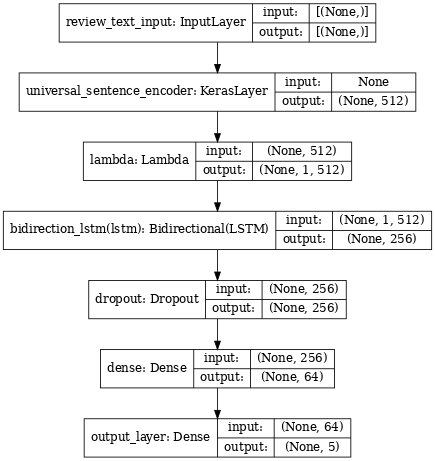

In [29]:
# Explore model visually
plot_model(
    model, dpi=60,
    show_shapes=True,
    expand_nested=True
)

<a id='5'></a>
# 5 | Train Baseline Model

To train this model we'll use Categorical Crossentropy as the loss function since this notebook approaches the problem at hand as a classification problem for multiple labels. As for the optimizer, we'll use the Adam optimizer with 0.001 as the (default) learning rate. 

To prevent the occurance of overfitting during training we'll have to make use of TensorFlow's Callback API to implement the EarlyStopping & ReduceLROnPlateau callbacks. The only metrics we'll track during the training of the model will be the loss and accuracy metrics.

**See the following for more information:**
- **Binary Crossentropy Loss Function:**
    - [Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names](https://gombru.github.io/2018/05/23/cross_entropy_loss/)
    - [TensorFlow Categorical Crossentropy Loss Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
- **Adam Optimizer:**
    - [Academic Paper | Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
    - [TensorFlow Adam Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- **TensorFlow Callback API:**
    - [EarlyStopping Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
    - [ReduceLROnPlateau Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)
- **TensorFlow Metrics:**
    - [TensorFlow Metrics Overview](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [30]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

<a id=5.1></a>
### Define Callbacks and Metrics for Model Training

In [31]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

<a id=5.2></a>
### Compile & Train Model

In [32]:
tf.random.set_seed(CFG.SEED)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

model_history = train_model(
    model, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_model.
Train on 48000 samples, validate on 12000 samples.
----------------------------------
Epoch 1/10
1500/1500 [==============================] - 49s 30ms/step - loss: 0.7271 - accuracy: 0.8555 - val_loss: 0.6931 - val_accuracy: 0.8661
Epoch 2/10
1500/1500 [==============================] - 44s 29ms/step - loss: 0.6915 - accuracy: 0.8663 - val_loss: 0.6879 - val_accuracy: 0.8677
Epoch 3/10
1500/1500 [==============================] - 43s 29ms/step - loss: 0.6834 - accuracy: 0.8689 - val_loss: 0.6859 - val_accuracy: 0.8688
Epoch 4/10
1500/1500 [==============================] - 43s 29ms/step - loss: 0.6767 - accuracy: 0.8708 - val_loss: 0.6840 - val_accuracy: 0.8696
Epoch 5/10
1500/1500 [==============================] - 43s 28ms/step - loss: 0.6698 - accuracy: 0.8732 - val_loss: 0.6834 - val_accuracy: 0.8701
Epoch 6/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.6635 - accuracy: 0.8759 - val_loss: 0.6826 - val_accuracy: 0.8687
Epoch 7/10
1500/15

In [33]:
# Evaluate the model
model_evaluation = model.evaluate(val_ds)

375/375 [==============================] - 7s 20ms/step - loss: 0.6817 - accuracy: 0.8693


In [34]:
# Generate model probabilities and associated predictions
train_probabilities = model.predict(train_ds, verbose=1)
train_predictions = tf.argmax(train_probabilities, axis=1)

1500/1500 [==============================] - 32s 20ms/step


In [35]:
# Generate model probabilities and associated predictions
val_probabilities = model.predict(val_ds, verbose=1)
val_predictions = tf.argmax(val_probabilities, axis=1)

375/375 [==============================] - 7s 20ms/step


<a id='6'></a>
# 6 | Model Performance Evaluation

Now that the model has trained on the data we need to inspect how well it performs on the validation data. In order to conduct this inspection we need to evaluate the performance of the model on the validation data and record evaluation metrics. Since the approach for this problem is a multi classification problem we'll make use of some well known classification metrics. Hence, we'll make use of the Scikit Learn library to inspect the model. We'll also use the following to inspect the model:

> - [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)
> - [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
> - [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
> - [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
> - [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 
> - [Matthews Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

<a id='6.1'></a>
### Plot Model Training History

In [36]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

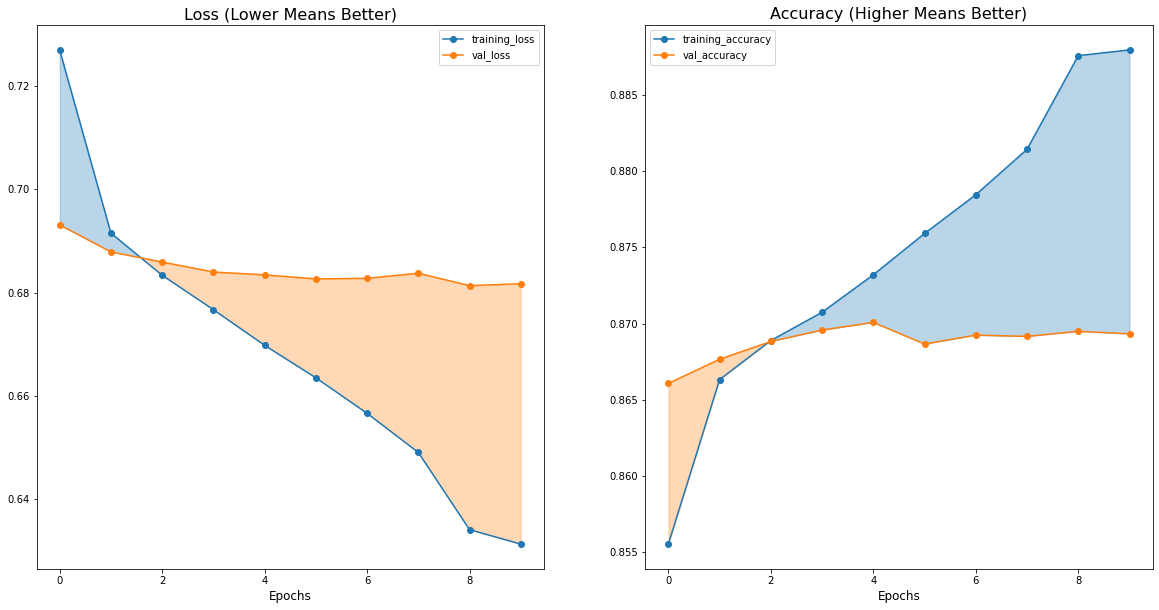

In [37]:
# plot model training history 
plot_training_curves(model_history)

<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    We observe that overfitting may have occured during the first few expochs. We also observe that the model reached a plateau on the validation loss.
</div>

<a id='6.2'></a>
### Plot Confusion Matrix

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

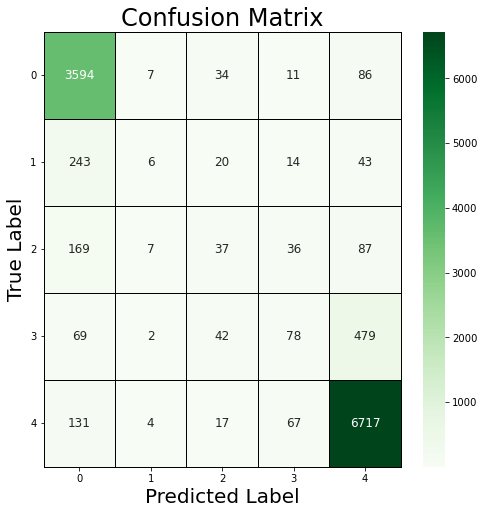

In [39]:
plot_confusion_matrix(
    val_df.Rating - 1, 
    val_predictions, 
    figsize=(8, 8))

<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    The model is able to classify the majority classes. However, the characteristics of a severly imbalanced dataset is present as the model struggles with predicting the minority classes.
</div>

<a id='6.3'></a>
### Generate Classification Report

In [40]:
print(classification_report(val_df.Rating - 1, val_predictions))

              precision    recall  f1-score   support

           0       0.85      0.96      0.91      3732
           1       0.23      0.02      0.03       326
           2       0.25      0.11      0.15       336
           3       0.38      0.12      0.18       670
           4       0.91      0.97      0.94      6936

    accuracy                           0.87     12000
   macro avg       0.52      0.44      0.44     12000
weighted avg       0.82      0.87      0.84     12000



<a id='6.4'></a>
### Record Classification Metrics

In [41]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_2_accuracy = top_k_accuracy_score(y_true, y_probabilities, k=2)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.5f}\n')
    print('_____________________________________________')
    print(f'top_2_accuracy_score:\t{top_2_accuracy:.5f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.5f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.5f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.5f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.5f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'top_2_accuracy_score': top_2_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    
    return preformance_scores

In [42]:
model_performance = generate_preformance_scores(val_df.Rating-1, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.86933

_____________________________________________
top_2_accuracy_score:	0.94458

_____________________________________________
precision_score:	0.82387

_____________________________________________
recall_score:		0.86933

_____________________________________________
f1_score:		0.83793

_____________________________________________
matthews_corrcoef:	0.76021



In [43]:
# Inspect Competition Metric: Mean-Absolute-Error
print('Competition Metric Score')
print('=========================')
print(f'Train MAE:\t{mean_absolute_error(train_new_df.rating_encoded, train_predictions):.5f}')
print(f'Validation MAE:\t{mean_absolute_error(val_df.rating_encoded, val_predictions):.5f}')
print('=========================')

Competition Metric Score
Train MAE:	0.17808
Validation MAE:	0.23300


<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    The model was able to achive a Matthews Correlation Coefficient of ~0.76 which is decent. A high MCC implies that the model's predictions are statistically of high quality and that the model may generalise to unseen samples. Looking at the Compition Metric, the model seems to score a low validation MAE and we can observe a significant difference between the training and validation MAE scores.
   <br><br>
   <b>Since the model was able to score a high MCC, we should expect a similar LB MAE score as the validation MAE.</b>
</div>

<a id='7'></a>
# 7 | Generate Submission

With the model performance evaluation complete, we need to generate the submission file.

<a id='7.1'></a>
### Preprocess Test Reviews

In [44]:
def predict(model, test_reviews):
    probabilities = model.predict(test_reviews, verbose=1)
    predictions = tf.argmax(probabilities, axis=1)
    return probabilities, predictions

In [45]:
# Preprocess Test Reviews
test_reviews = test_df['Review'].apply(text_preprocessor)
test_reviews.shape

(40000,)

<a id='7.2'></a>
### Generate Test Predictions

In [46]:
# Generate Test Predictions
test_probabilities, test_predictions = predict(model, test_reviews)

1250/1250 [==============================] - 26s 20ms/step


<a id='7.3'></a>

In [47]:
# Use the sample_subission dataframe to create the
# submission csv for the test set predictions
submission_df['Rating'] = test_predictions + 1 # Decode labels 

# View first 5 submission samples 
submission_df.head(5)

,Id,Rating
0,60000,1
1,60001,5
2,60002,1
3,60003,5
4,60004,1


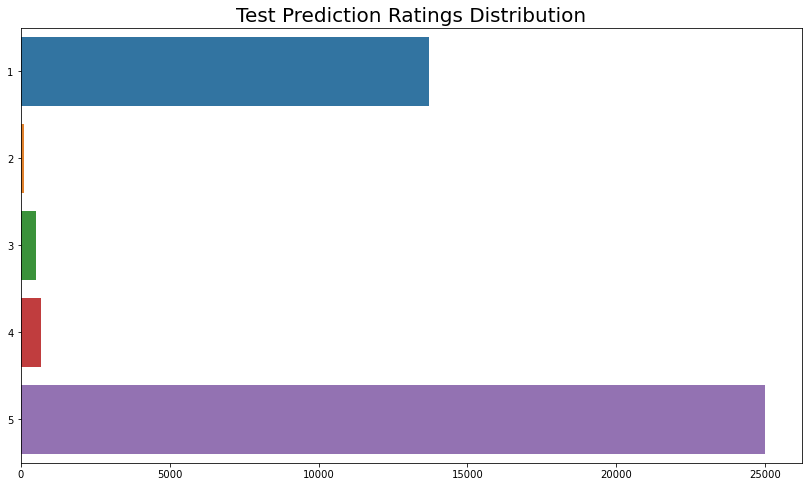

In [48]:
# View Test Predictions Ratings Distribution
plt.figure(figsize=(14, 8))
plt.title('Test Prediction Ratings Distribution', fontsize=20)
test_predictions_distribution = submission_df['Rating'].value_counts().sort_values()

sns.barplot(x=test_predictions_distribution.values,
            y=list(test_predictions_distribution.keys()),
            orient="h");

<div class="alert alert-block alert-info">
    <h4>Observation</h4>
    The test predictions resemble the train ratings distribution. However, we observe that the minority classes are overshadowed by the majority classes. This behavior should be addressed in future experiments.
</div>

<a id='7.4'></a>
### Generate Submission.csv

In [49]:
# Create submission csv
submission_df.to_csv('submission.csv', index=False)

<a id='conclusion'></a>
# <center><font style='color:#1D3557;'>Conclusion</font></center>

In this notebook we built a baseline model to predict the sentiment of company reviews left by customers. We achieved this by using the Universal Sentence Encoder to generate text embeddings which where representative of the review texts, and fed these embeddings to a classification head. We achieved a Matthews Correlation Coefficient of ~0.76, which implies that the model's predictions are statistically of high quality and that the model will generalise to unseen samples.

However, when looking at the model's confusion matrix and classification report we observe the characteristics of a severly imbalanced dataset. The model is unable to correctly predict review ratings which are between 1 and 5. Also, the classification approach might be adding to this bad model behavior as the loss function does not aim to minimize the competition metric (Mean Absolute Error). Therefore, it is recommended that an **ordinal text regression approach** should be followed as this approach will be focuse on minimizing the competition's metric and may achieve better results.

<br>

<center>
    <div class="alert alert-block alert-success">  
        <h2>Thank you for taking the time to check out my notebook and I hope you found this insightful!</h2>
    </div>
</center>